In [1]:
import dask.dataframe as dd
import geopandas
import planetary_computer
import pystac_client
import pandas as pd
from dask.distributed import Client, LocalCluster
import dask_geopandas as dgpd

In [2]:
# Start cluster
cluster = LocalCluster()
client = Client(cluster)

print(cluster.dashboard_link)

2025-11-14 10:00:14,747 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/fbrito/.local/share/hatch/env/virtual/dask-flatgeobuf/2-ecuYQ1/dask-flatgeobuf/lib/python3.13/site-packages/tornado/websocket.py", line 965, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/home/fbrito/.local/share/hatch/env/virtual/dask-flatgeobuf/2-ecuYQ1/dask-flatgeobuf/lib/python3.13/site-packages/tornado/web.py", line 3375, in wrapper
    return method(self, *args, **kwargs)
  File "/home/fbrito/.local/share/hatch/env/virtual/dask-flatgeobuf/2-ecuYQ1/dask-flatgeobuf/lib/python3.13/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired. Configure the app with a larger value for --session-token-expiratio

http://127.0.0.1:8787/status


2025-11-14 10:00:19,749 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/fbrito/.local/share/hatch/env/virtual/dask-flatgeobuf/2-ecuYQ1/dask-flatgeobuf/lib/python3.13/site-packages/tornado/websocket.py", line 965, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/home/fbrito/.local/share/hatch/env/virtual/dask-flatgeobuf/2-ecuYQ1/dask-flatgeobuf/lib/python3.13/site-packages/tornado/web.py", line 3375, in wrapper
    return method(self, *args, **kwargs)
  File "/home/fbrito/.local/share/hatch/env/virtual/dask-flatgeobuf/2-ecuYQ1/dask-flatgeobuf/lib/python3.13/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired. Configure the app with a larger value for --session-token-expiratio

In [3]:
catalog = pystac_client.Client.open(
     "https://planetarycomputer.microsoft.com/api/stac/v1/"
 )
collection = catalog.get_collection("landsat-c2-l2")

asset = planetary_computer.sign(collection.assets["geoparquet-items"])



In [4]:



df = dgpd.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"], npartitions=40, columns=["landsat:wrs_path", "landsat:wrs_row", "geometry"]
)
#df.head()

In [5]:
acq_by_tile = (
    df.groupby(["landsat:wrs_path", "landsat:wrs_row"])
        .size()
        .compute()
        .reset_index(name="count")
)

In [6]:
acq_by_tile

,landsat:wrs_path,landsat:wrs_row,count
0,002,024,100
1,003,027,637
2,005,024,864
3,005,028,960
4,005,029,933
...,...,...,...
23242,219,090,1
23243,226,052,1
23244,021,083,18
23245,231,045,3


In [7]:
tile_geoms = (
    df[["landsat:wrs_path", "landsat:wrs_row", "geometry"]]
    .drop_duplicates(subset=["landsat:wrs_path", "landsat:wrs_row"])
    .compute()
)

In [8]:
acq_by_tile_gdf = tile_geoms.merge(
    acq_by_tile,
    on=["landsat:wrs_path", "landsat:wrs_row"],
    how="left",
)

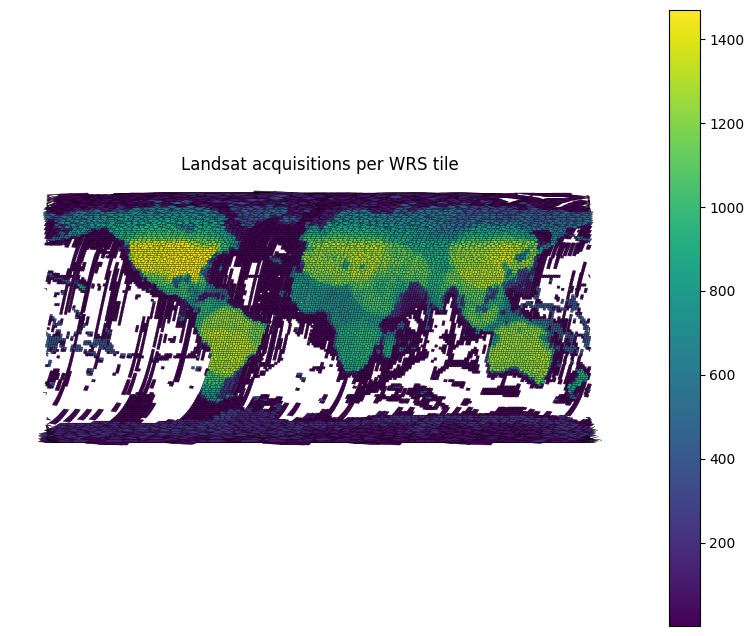

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))

acq_by_tile_gdf.plot(
    column="count",
    ax=ax,
    legend=True,
    cmap="viridis",
    edgecolor="black",
    linewidth=0.2,
)

ax.set_title("Landsat acquisitions per WRS tile")
ax.set_axis_off()

fig.savefig("acq_by_tile.png", dpi=200, bbox_inches="tight")

In [10]:
aa

NameError: name 'aa' is not defined

In [ ]:
df.head()

Task exception was never retrieved
future: <Task finished name='Task-79240' coro=<Client._gather.<locals>.wait() done, defined at /home/fbrito/.local/share/hatch/env/virtual/dask-flatgeobuf/2-ecuYQ1/dask-flatgeobuf/lib/python3.13/site-packages/distributed/client.py:2388> exception=AllExit()>
Traceback (most recent call last):
  File "/home/fbrito/.local/share/hatch/env/virtual/dask-flatgeobuf/2-ecuYQ1/dask-flatgeobuf/lib/python3.13/site-packages/distributed/client.py", line 2397, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

In [ ]:
ddf = dd.read_parquet(asset.href, columns=["landsat:wrs_path", "landsat:wrs_row"])


ValueError: An error occurred while calling the read_parquet method registered to the pandas backend.
Original Message: unable to connect to account for Must provide either a connection_string or account_name with credentials!!

In [ ]:
from shapely.geometry import box

roi = box(8.5, 44, 12.5, 46.5)
xmin, ymin, xmax, ymax = roi.bounds

# NEW: Build spatial partitions once
df = df.calculate_spatial_partitions()

# 1. Bounding-box filter using .cx
subset = df.cx[xmin:xmax, ymin:ymax]

# 2. True spatial filtering
def spatial_filter(gdf, roi=roi):
    return gdf[gdf.intersects(roi)]

subset = subset.map_partitions(spatial_filter, meta=df._meta)

# 3. Trigger execution
result = subset.compute()

2025-11-14 09:26:27,600 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.35 GiB -- Worker memory limit: 7.54 GiB
2025-11-14 09:26:28,432 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 6.14 GiB -- Worker memory limit: 7.54 GiB
2025-11-14 09:26:30,309 - distributed.nanny - WARNING - Restarting worker
2025-11-14 09:26:37,219 - distributed.worker.memory - WARNING - Worker is at 90% memory usage. Pausing worker.  Process memory: 6.83 GiB -- Worker memory limit: 7.54 GiB
2025-11-14 09:26:37,220 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#

KilledWorker: Attempted to run task ('read_parquet-1950bf69918fe8b6ee4ffcef29dffba6', 43) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:38251. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

2025-11-14 09:27:47,118 - distributed.nanny - WARNING - Restarting worker
2025-11-14 09:27:49,628 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.06 GiB -- Worker memory limit: 7.54 GiB
2025-11-14 09:27:49,629 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 6.06 GiB -- Worker memory limit: 7.54 GiB
2025-11-14 09:27:55,305 - distributed.nanny - WARNING - Restarting worker
2025-11-14 09:27:58,935 - distributed.nanny - WARNING - Restarting worker


In [ ]:
from shapely.geometry import box

roi = box(8.5, 44, 12.5, 46.5)
xmin, ymin, xmax, ymax = roi.bounds
subset = df.cx[xmin:xmax, ymin:ymax]

NotImplementedError: Not yet implemented if the GeoDataFrame has no known spatial partitions (you can call the 'calculate_spatial_partitions' method to set it)

In [ ]:
import geopandas as gpd

def spatial_filter(gdf, roi=roi):
    return gdf[gdf.intersects(roi)]

subset = subset.map_partitions(spatial_filter, meta=df._meta)
result = subset.compute()

NameError: name 'subset' is not defined

In [ ]:
from shapely.geometry import box

roi = box(8.5, 44, 12.5, 46.5)
subset = df[df.intersects(roi)]
result = subset.compute()

2025-11-14 09:17:48,807 - distributed.nanny - WARNING - Restarting worker
2025-11-14 09:17:49,527 - distributed.nanny - WARNING - Restarting worker
2025-11-14 09:18:02,071 - distributed.worker.memory - WARNING - Worker is at 89% memory usage. Pausing worker.  Process memory: 6.78 GiB -- Worker memory limit: 7.54 GiB
2025-11-14 09:18:02,072 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 6.78 GiB -- Worker memory limit: 7.54 GiB
2025-11-14 09:18:05,188 - distributed.nanny - WARNING - Restarting worker
2025-11-14 09:18:10,955 - distributed.nanny - WARNING - Restarting worker
2025-11-14 09:18:11,982 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

KilledWorker: Attempted to run task ('read_parquet-30830fee1c18a8c02f042651be601d92', 6) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:33811. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

2025-11-14 09:19:37,901 - distributed.worker.memory - WARNING - Worker is at 86% memory usage. Pausing worker.  Process memory: 6.55 GiB -- Worker memory limit: 7.54 GiB
2025-11-14 09:19:37,902 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 6.55 GiB -- Worker memory limit: 7.54 GiB
2025-11-14 09:19:43,321 - distributed.nanny - WARNING - Restarting worker
2025-11-14 09:19:56,647 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.49 GiB -- Worker memory limit: 7.54 GiB
2025-11-14 09:19:59,897 - distributed.worker.memor

In [ ]:
list(df.columns)

['assets',
 'bbox',
 'collection',
 'geometry',
 'id',
 'links',
 'stac_extensions',
 'stac_version',
 'type',
 'created',
 'datetime',
 'description',
 'eo:cloud_cover',
 'gsd',
 'instruments',
 'landsat:cloud_cover_land',
 'landsat:collection_category',
 'landsat:collection_number',
 'landsat:correction',
 'landsat:scene_id',
 'landsat:wrs_path',
 'landsat:wrs_row',
 'landsat:wrs_type',
 'platform',
 'proj:epsg',
 'proj:shape',
 'proj:transform',
 'sci:doi',
 'view:off_nadir',
 'view:sun_azimuth',
 'view:sun_elevation']

In [ ]:
acq_by_tile = (
    df.groupby(["landsat:wrs_path", "landsat:wrs_row"])
        .size()
        .compute()
        .reset_index(name="count")
)

Task exception was never retrieved
future: <Task finished name='Task-85277' coro=<Client._gather.<locals>.wait() done, defined at /home/fbrito/.local/share/hatch/env/virtual/dask-flatgeobuf/2-ecuYQ1/dask-flatgeobuf/lib/python3.13/site-packages/distributed/client.py:2388> exception=AllExit()>
Traceback (most recent call last):
  File "/home/fbrito/.local/share/hatch/env/virtual/dask-flatgeobuf/2-ecuYQ1/dask-flatgeobuf/lib/python3.13/site-packages/distributed/client.py", line 2397, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

In [ ]:
#area = df.geometry.area.compute()

/home/fbrito/.local/share/hatch/env/virtual/dask-flatgeobuf/2-ecuYQ1/dask-flatgeobuf/lib/python3.13/site-packages/dask_geopandas/expr.py:186: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  meta = getattr(self._meta, attr)
2025-11-13 15:27:51,001 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.33 GiB -- Worker memory limit: 7.54 GiB
2025-11-13 15:27:52,569 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.04 GiB -- Worker memory limit: 7.54 GiB
2025-11-13 15:27:55,513 - distributed.nanny - WARNING - Restarting worker
2025-11-13 15:27:58,949 - distributed.nanny -

KeyboardInterrupt: 

In [ ]:
# out = df.map_partitions(
#     lambda g: g.geometry.area, 
#     meta=("area", "float64")
# ).compute()

2025-11-13 15:20:13,323 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.44 GiB -- Worker memory limit: 7.54 GiB
2025-11-13 15:20:14,767 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.42 GiB -- Worker memory limit: 7.54 GiB
2025-11-13 15:20:20,874 - distributed.nanny - WARNING - Restarting worker
2025-11-13 15:20:22,732 - distributed.worker.memory - WARNING - Worker is at 90% memory usage. Pausing worker.  Process memory: 6.81 GiB -- Worker memory limit: 7.54 GiB
2025-11-13 15:20:26,356 - distributed.nanny - WARN

KeyboardInterrupt: 